In [97]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import randrange, uniform
from time import time
import glob
import shutil
import itertools
from time import time

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

sns.set()

# Read image RGB

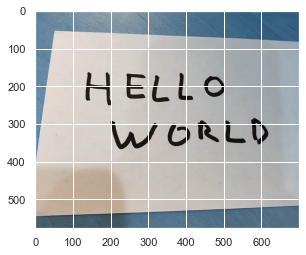

In [98]:
image_color = cv2.imread('img/hello_world.png', cv2.COLOR_BGR2RGB)
plt.imshow(image_color)
plt.show()

# Remove noise

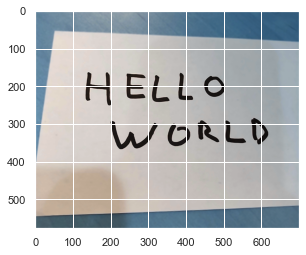

In [99]:
image_denoise = cv2.fastNlMeansDenoisingColored(image_color, None, 25, 25, 7, 5)
plt.imshow(image_denoise)
plt.show()

# Grayscale

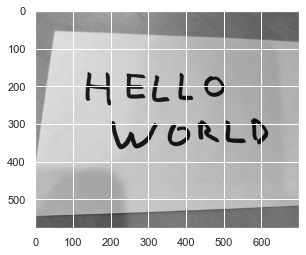

In [100]:
image_gray = cv2.cvtColor(image_denoise, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap='gray')
plt.show()

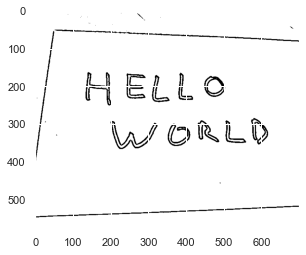

In [101]:
image_binary = cv2.adaptiveThreshold(image_gray, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,5)
plt.imshow(image_binary, cmap='gray')
plt.show()

# Thinning

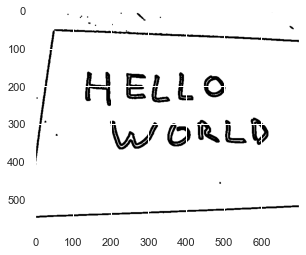

In [102]:
kernel = np.ones((3,3),np.uint8)
image_thin = cv2.erode(image_binary, kernel, iterations = 1)
plt.imshow(image_thin, cmap='gray')
plt.show()

# Character level segmentation

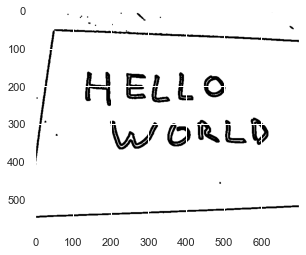

In [103]:
mask = cv2.inRange(image_thin, 255, 255)
plt.imshow(mask, cmap='gray')
plt.show()

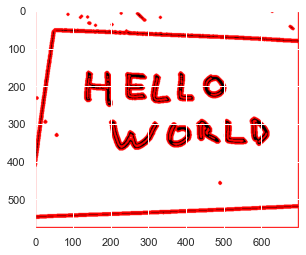

In [104]:
image = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(image, contours, -1, (255, 0, 0), 3)
plt.imshow(image)
plt.show()

In [105]:
gray = mask
chars = []

In [106]:
for c in contours:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)

    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
        # extract the character and threshold it to make the character
        # appear as *white* (foreground) on a *black* background, then
        # grab the width and height of the thresholded image
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape

        # if the width is greater than the height, resize along the
        # width dimension
        if tW > tH:
            thresh = imutils.resize(thresh, width=32)

        # otherwise, resize along the height
        else:
            thresh = imutils.resize(thresh, height=32)

        # re-grab the image dimensions (now that its been resized)
        # and then determine how much we need to pad the width and
        # height such that our image will be 32x32
        (tH, tW) = thresh.shape
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)

        # pad the image and force 32x32 dimensions
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
            left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0))
        padded = cv2.resize(padded, (32, 32))

        # prepare the padded image for classification via our
        # handwriting OCR model
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)

        # update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))

In [107]:
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

In [108]:
np.squeeze(chars).shape

(24, 32, 32)

In [109]:
chars_new = [None] * len(chars)
for i in range(len(chars)):
    img = chars[i]
    img = cv2.resize(img, (28, 28))
    #img = np.expand_dims(img, 0)
    chars_new[i] = img
chars_new = np.array(chars_new)
chars_new.shape

(24, 28, 28)

In [110]:
model = load_model("model_h5_format/model.h5")

In [111]:
preds = model.predict(chars_new)

In [112]:
output_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
                 'A','B','C','D','E','F','G','H','I','J','K','L','M',
                 'N', 'O','P','Q','R','S', 'T','U','V','W','X','Y','Z']

In [118]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]
labelNames[29] == output_labels[29]

True

In [113]:
for p in preds:
    print(output_labels[np.argmax(p)])

7
1
W
2
2
2
2
7
1
D
7
7
1
7
5
T
L
1
L
L
L
H
7
4


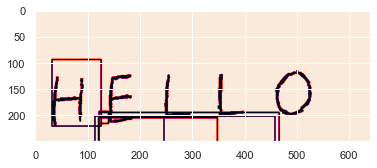

In [57]:
mask = cv2.inRange(image_thin, 255, 255)
gray = mask

# Apply adaptive threshold
thresh = cv2.adaptiveThreshold(gray,255, 1, 1, 11, 2)
thresh_color = cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)

# apply some dilation and erosion to join the gaps
thresh = cv2.dilate(thresh, None, iterations = 3)
thresh = cv2.erode(thresh, None, iterations = 2)

# Find the contours
contours,hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# For each contour, find the bounding rectangle and draw it


for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    roi = gray[y:y+h, x:x+w]
    cv2.rectangle(gray,(x,x+w),(y,y+h),(0,0,0),2)

    cv2.rectangle(thresh_color,(x,y),(x+w,y+h),(0,255,0),2)

# Finally show the image
plt.imshow(gray)
plt.show()

In [10]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

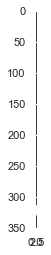

ValueError: zero-size array to reduction operation minimum which has no identity

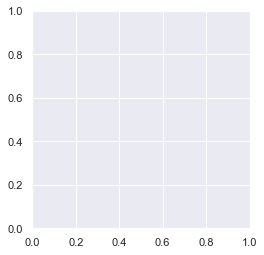

In [13]:

img = mask
img = cv2.resize(img, (960, 540)) 

hImg, wImg= img.shape
# by default, cv2 shows images in BGR format. We want the images in RGB format.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.bitwise_not(img)


boxes = pytesseract.image_to_boxes(img)


for b in boxes.splitlines():
    b = b.split(' ')
    x, y, w, h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
    roi = img[x:hImg-w, w:hImg-h]
    plt.imshow(roi)
    plt.show()

In [30]:
def findHorizontalLines(img):

    gray = img
    
    # set threshold to remove background noise
    thresh = cv2.threshold(gray,30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    
    # define rectangle structure (line) to look for: width 100, hight 1. This is a 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200,1))
    
    # Find horizontal lines
    lineLocations = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    return lineLocations

In [32]:
print(sum(findHorizontalLines(mask)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 